In [2]:
import pandas as pd
import numpy as np
import backtrader as bt
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
sns.set()
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 18,9
pd.set_option('display.max_colwidth', -1)
pd.plotting.register_matplotlib_converters()
#plt.style.use('fivethirtyeight')

In [4]:
#class St(bt.Strategy):
#    def __init__(self):
#        self.ema = bt.indicators.ExponentialMovingAverage(self.data)
#        self.bol = bt.indicators.BollingerBands(self.data)

In [37]:
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=1)   # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position

In [38]:
ticker = 'MSFT'

In [39]:
end = datetime.now()
start = datetime(end.year - 3, end.month , end.day)

In [40]:
data = bt.feeds.GenericCSVData(
        fromdate=start,
        todate=end,
        dataname=(f"../data/ticks/{ticker}.csv"),
        dtformat=('%Y-%m-%d'),
        openinterest=-1,
        nullvalue=0.0,
        plot=True
    )

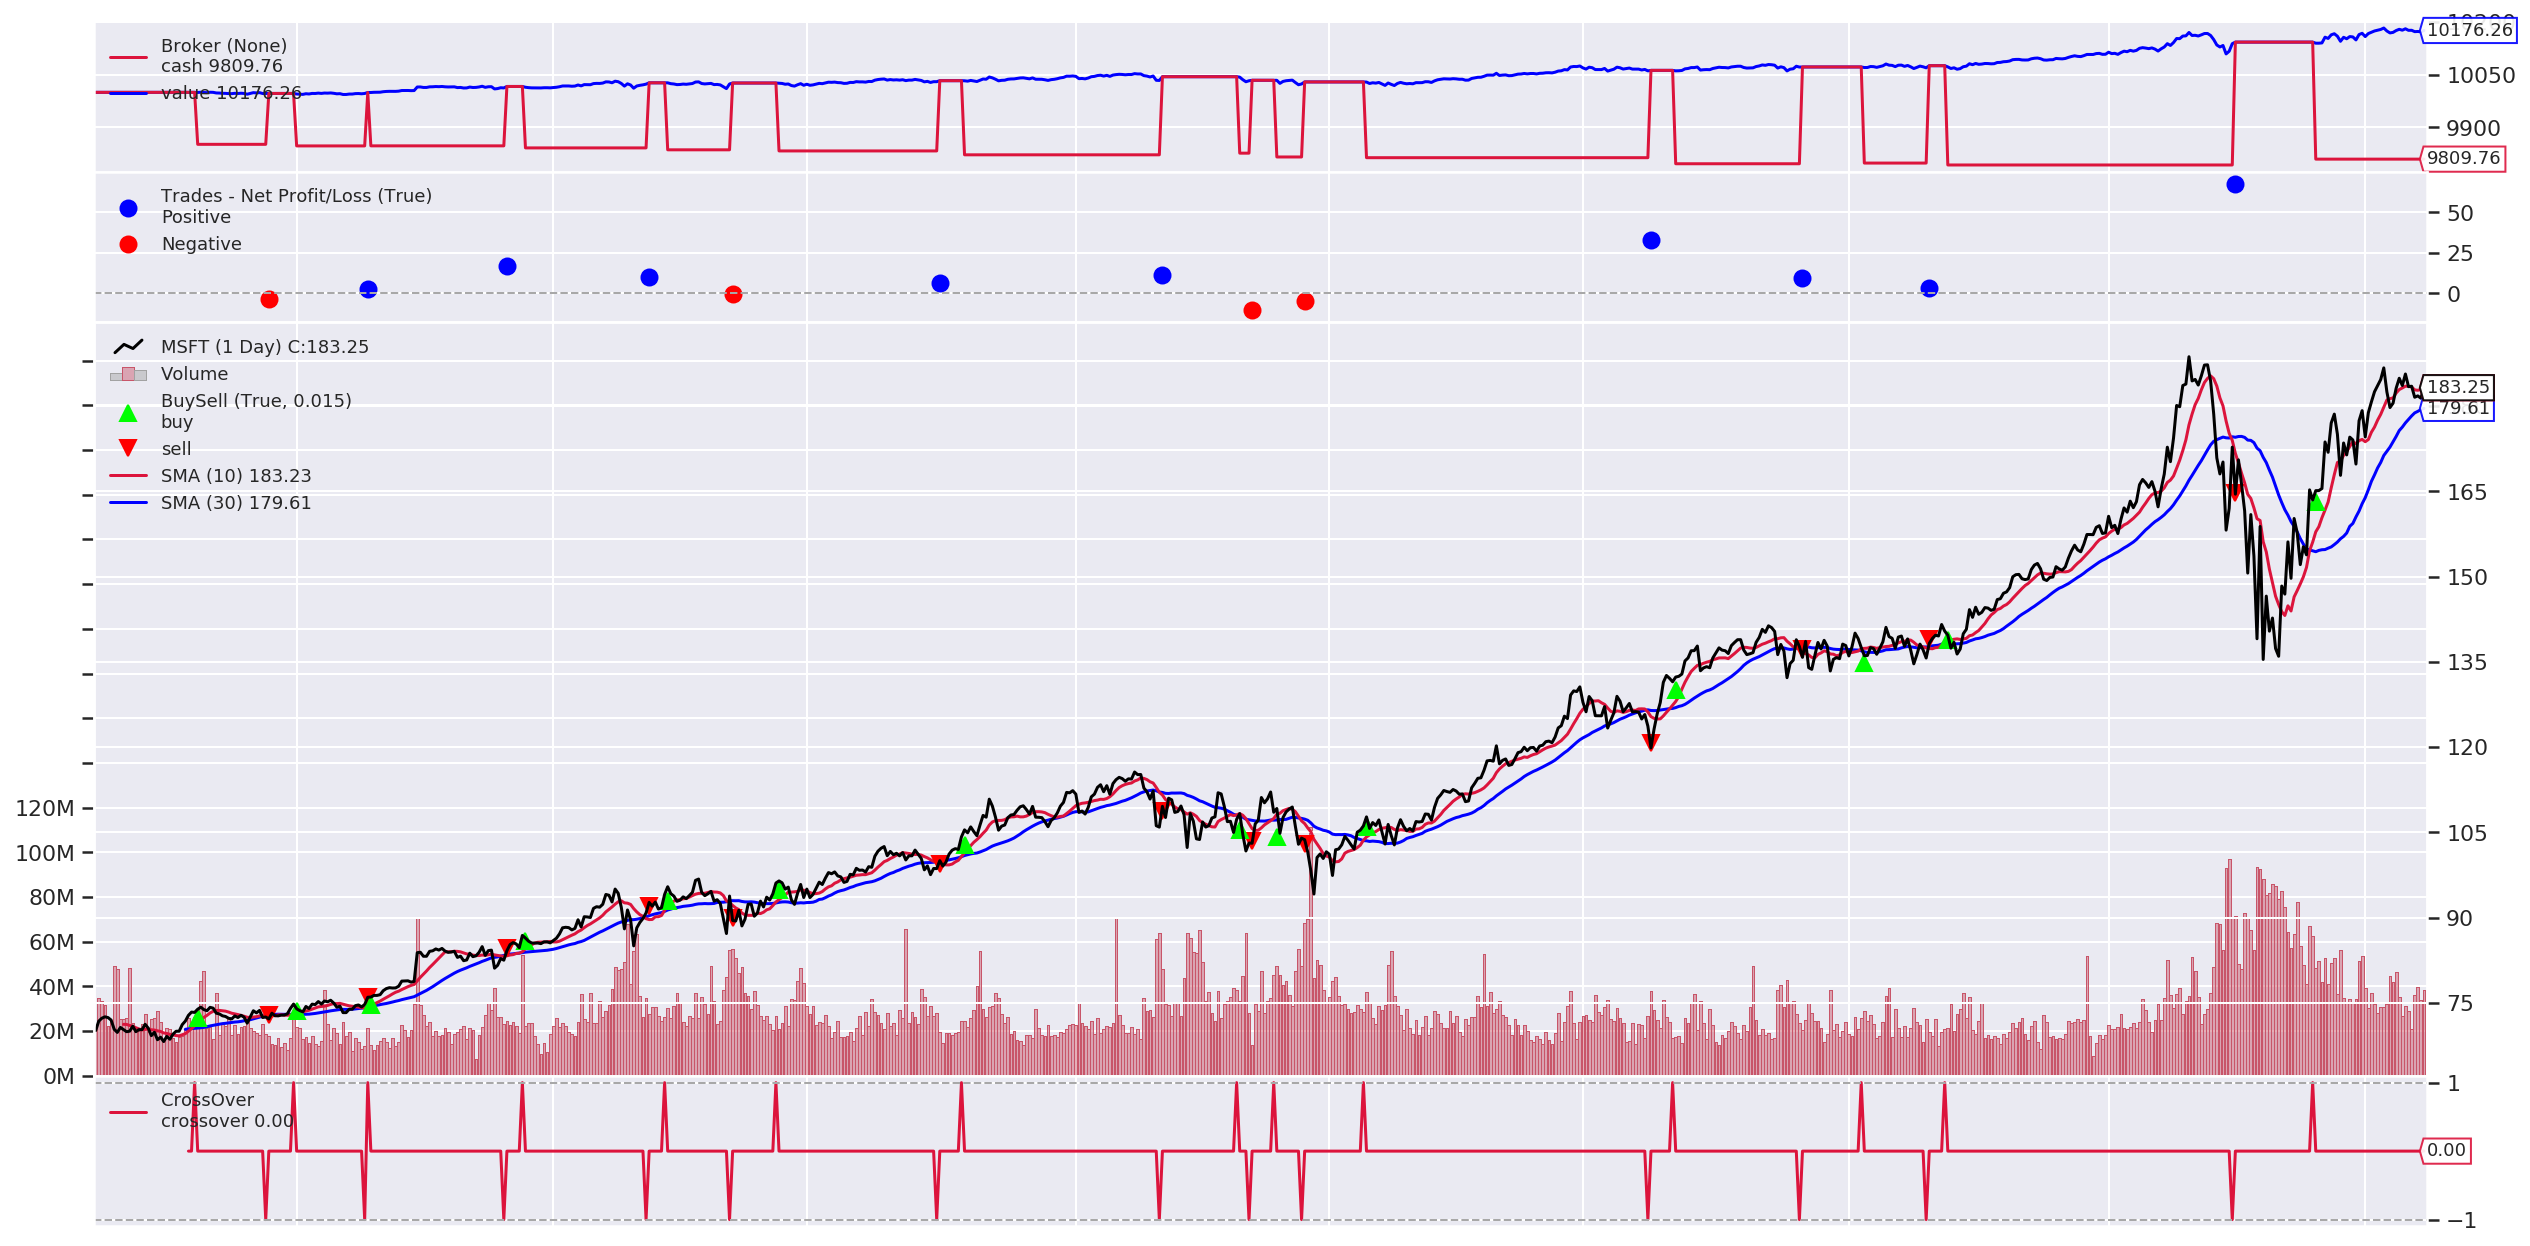

CPU times: user 2.11 s, sys: 261 ms, total: 2.38 s
Wall time: 1.99 s


[[<Figure size 1296x648 with 5 Axes>]]

In [41]:
%%time
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(SmaCross)
cerebro.run()
cerebro.plot(iplot=False)